#### Case: Isobaric evaporation of ammonia in a large tank for long-term storage


In [15]:
# Ensure that python finds the submodules
import sys
sys.path.append("..") # Adds higher directory to python modules path.

# Scientific computing
import numpy as np

# Visualisation
import matplotlib.pyplot as plt

## Module imports
# Import the storage tank Class
from cryoevap.storage_tanks import Tank 

# Import Cryogen class
from cryoevap.cryogens import Cryogen

# Import Pandas for data handling
import pandas as pd


#### Setup tank and cryogen properties

In [2]:
# Dimensions
# Wall thickness 
e = 0.4572 #m

# Vertically orientated cylindrical tank volume
V_tank = 88023.6952 #m^3

# Aspect ratio
a = 0.5

# Internal diameter
d_i  = ((4 * V_tank)/(np.pi * a))**(1/3) # internal diameter / m
d_o  = d_i + 2*e # external diameter / m

# Initial liquid filling / Dimensionless
LF = 0.95

# Initialize large-scale tank
large_tank = Tank(d_i, d_o, V_tank, LF)


In [3]:
# LNG tank properties
Q_roof = 0           # Roof heat ingress / W
T_air  = 5.3286+273.15 # Temperature of the environment K

# Set overall heat transfer coefficient through the walls for liquid and vapour
U_L = 8.86344e-02   # W/m2/K
U_V = 8.86344e-02   # W/m2/K
U_b = 8.80129e-2      # W/m2/K
h_L = 135.08  # W/m2/K

# Set wall tank properties
Init_T = True   # True: T_air, False: T_L
k_w    = 0.0411 # W/mK
cp_w   = 900    # J/kg K
rho_w  = 60     # kg/m3

# Specify heat transfer rate at the bottom to prevent ground heating
Q_b = None # W, 

# Specify tank operating pressure
P = 101325 # Pa

large_tank.set_HeatTransProps(U_L, U_V, T_air, Q_b_fixed = None, Q_roof = 0, eta_w = 0.70, k_w = k_w, rho_w = rho_w, cp_w = cp_w, h_L = h_L, T_init = Init_T)
# Bottom heat ingress
large_tank.U_b = U_b

# Initialise cryogen
ammonia = Cryogen(name = "ammonia")
ammonia.set_coolprops(P)

# Set cryogen
large_tank.cryogen = ammonia

# Calculate initial evaporation rate
print("The initial evaporation rate of " + ammonia.name + " is %.1f kg/h" % (large_tank.b_l_dot * 3600))

The initial evaporation rate of ammonia is 78.3 kg/h


Calculate initial evaporation rate and transient period

In [4]:
# Calculate initial evaporation rate
print("The initial evaporation rate of " + ammonia.name + " is %.1f kg/h" % (large_tank.b_l_dot * 3600))

# Estimate transient period duration
print("Transient period = %.3f s " % large_tank.tau)

# Minimum number of hours to achieve steady state 
tau_h = (np.floor(large_tank.tau / 3600) + 1)

# Print simulation time of the transient period for short-term storage
print("Simulation time: %.0i h" % tau_h )

# Calculate boil-off rate
BOR = (large_tank.b_l_dot * 24 * 3600) / (large_tank.V * large_tank.LF * large_tank.cryogen.rho_L)
print("BOR = %.3f %%" % (BOR * 100))

The initial evaporation rate of ammonia is 78.3 kg/h
Transient period = 360343.536 s 
Simulation time: 101 h
BOR = 0.003 %


#### Setup environmental properties

In [5]:
T_env_avg = 5.3286+273.15     # K
T_range   = 15                # K
h_env     = 14.839               # W/m2K   

p_anual   = np.array([-0.00022, 0.08395, 0.989792])

large_tank.set_EnvironmentalProps(T_avg_day = T_env_avg, T_range_day = T_range, h_env = h_env,
                                  p_anual=None)

#### Simulation setup and execution

In [6]:
# Define vertical spacing
dz = 0.05
dr = 0.01

# Calculate number of nodes
n_z = 1 + int(np.round(large_tank.l_V/dz, 0))
n_r = 1 + int(np.round((large_tank.d_o - large_tank.d_i)/(2*dr), 0))


# Define dimensionless computational grid
large_tank.z_grid = np.linspace(0, 1, n_z)

large_tank.r_grid = np.linspace(0, 1, n_r)

# Insulated roof
large_tank.U_roof = 0

# Define evaporation time
evap_time = 3600 * 24 * 7 * 3 # 3 weeks

# Time step to record data, relevant for plotting integrated quantities
# such as the vapour to liquid heat transfer rate, Q_VL
large_tank.time_interval = 3600

# Time step to plot each vapour temperature profile
large_tank.plot_interval = evap_time/6

# Simulate the evaporation
large_tank.evaporate(evap_time)

Export results to `Results/Data` folder

In [7]:
# Destination folder
folder = '../Results/Data/'

# Save large_tank.data to CSV
large_tank.export_data(f'{folder}Example_LF95.csv')

#### Visualisation of results

#### Vapour temperature

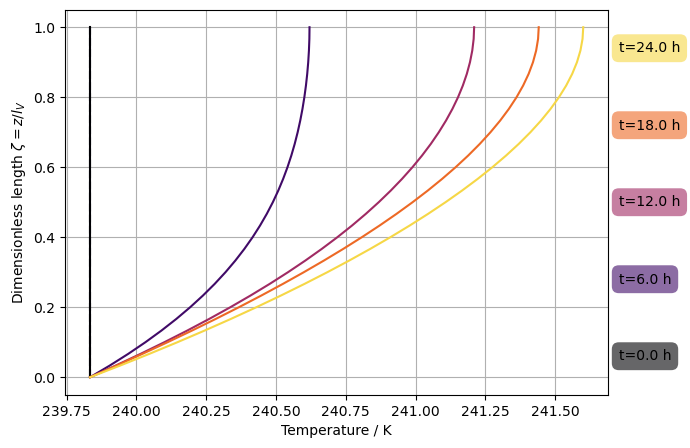

In [7]:
# Visualise the plot
large_tank.plot_tv(t_unit='h')

Visualise liquid and vapour heat ingresses, $\dot{Q}_{\text{L}}$ and  $\dot{Q}_{\text{V}}$.

The plot also shows the vapour to liquid heat ingress, $\dot{Q}_{VL}$, and  the partition of the vapour heat ingress that is transferred to the interface by the wall directly, $\dot{Q}_{\text{V,w}}$

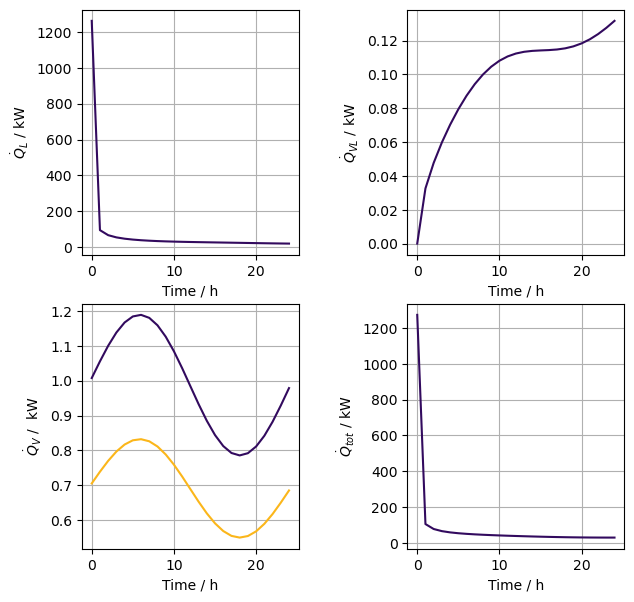

In [8]:
large_tank.plot_Q(unit='kW', t_unit='h')

#### Plot liquid volume

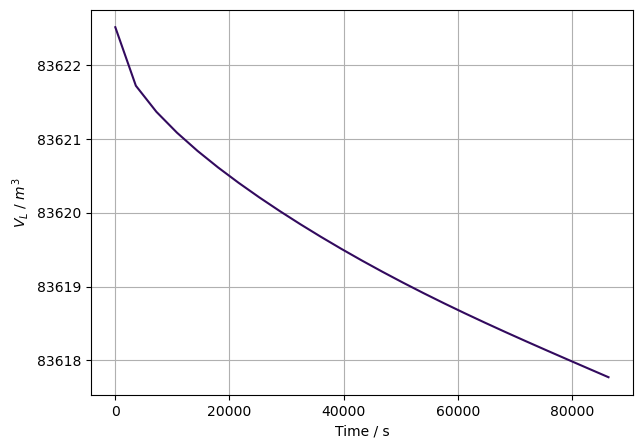

In [9]:
large_tank.plot_V_L()

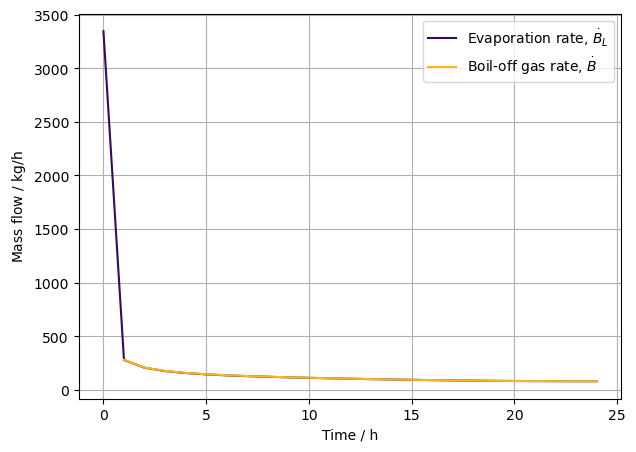

In [10]:
large_tank.plot_BOG(unit='kg/h', t_unit='h')

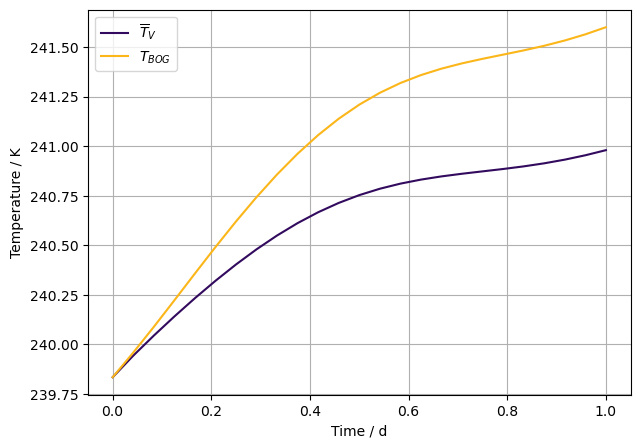

In [11]:
large_tank.plot_tv_BOG(t_unit='d')

#### Plot wall properties

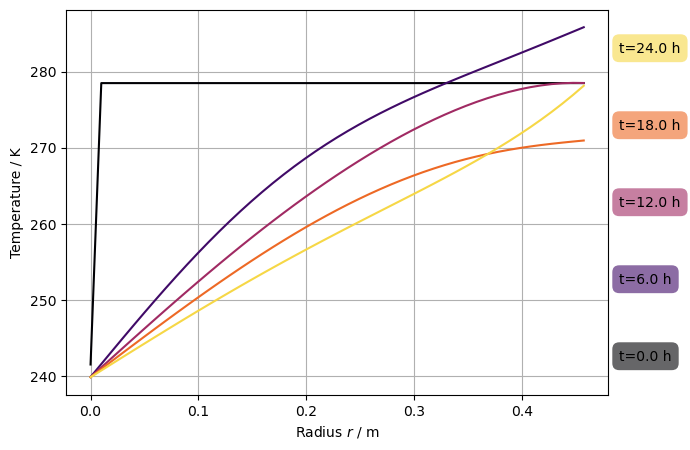

In [12]:
# Using real EDO
large_tank.plot_tw(t_unit='h')


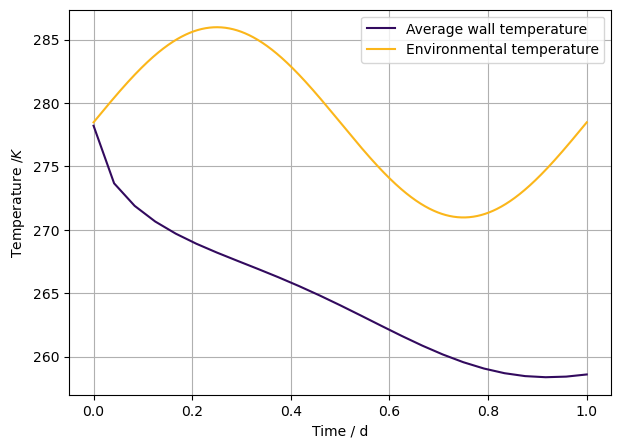

In [13]:
large_tank.plot_T_w_avg(t_unit='d')

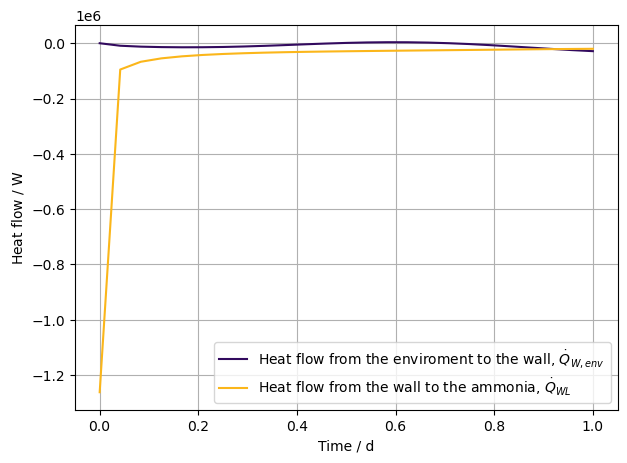

In [14]:
large_tank.plot_Q_w(unit='W', t_unit='d')


#### References



F. Huerta, V. Vesovic, A realistic vapour phase heat transfer model for the weathering of LNG stored in large tanks, Energy, 174 (2019) 280-291.